<a href="https://colab.research.google.com/github/namigabbasov/ai-literacy-bibliometric-analysis/blob/main/scripts/RQ2_author_productivity_and_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RQ2 — Knowledge Creation and Collaboration**



## Setup: Install and Import Required Libraries

In [ ]:
resol=1000

In [ ]:
!pip install -q python-louvain networkx matplotlib seaborn pandas numpy pycountry
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import re
import community as community_louvain  # python-louvain
import pycountry
from itertools import combinations
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import community.community_louvain as community_louvain

import re, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
import community.community_louvain as community_louvain
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
sns.set(style="whitegrid")
import networkx as nx
import itertools
from networkx.algorithms import community


##

## Load AI Literacy Dataset from GitHub

In [ ]:
url = "https://raw.githubusercontent.com/namigabbasov/ai-literacy-bibliometric-analysis/refs/heads/main/data/ai_literacy.csv"
df = pd.read_csv(url, low_memory=False)

## Author Collaboration Network

##

In [ ]:
dfA = df.copy()
dfA['Cited by'] = pd.to_numeric(dfA['Cited by'], errors='coerce').fillna(0)

def split_authors_cell(x):
    if pd.isna(x):
        return []
    parts = [p.strip() for p in str(x).split(';') if p.strip()]
    return parts

dfA['author_list'] = dfA['Authors'].apply(split_authors_cell)

authors_exploded = dfA.explode('author_list').rename(columns={'author_list': 'author'})
authors_exploded['author'] = authors_exploded['author'].astype(str).str.strip()
invalid_authors = ["", "nan", "none", "null", "n.a."]
authors_exploded = authors_exploded[
    ~authors_exploded['author'].str.lower().isin(invalid_authors)
]


author_pub_counts = (
    authors_exploded['author']
        .value_counts()
        .rename_axis('author')
        .reset_index(name='n_pubs')
)


TOP_N = 10
top_authors = author_pub_counts.head(TOP_N)


plt.figure(figsize=(10, 6), dpi=resol)
top_authors_sorted = top_authors.sort_values("n_pubs", ascending=False)
labels = [textwrap.fill(a, 30) for a in top_authors_sorted['author']]
values = top_authors_sorted['n_pubs'].values
plt.barh(labels, values, color="gray", edgecolor="black", linewidth=0.9)
plt.gca().invert_yaxis()
plt.title("Top 10 Authors by Number of Publications", fontsize=16, fontweight='bold')
plt.xlabel("Number of Publications", fontsize=14)
plt.ylabel("Author", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
plt.subplots_adjust(left=0.30)
plt.tight_layout()
plt.show()

In [ ]:
dfA = df.copy()
dfA['Cited by'] = pd.to_numeric(dfA['Cited by'], errors='coerce').fillna(0)


def split_authors(x):
    if pd.isna(x):
        return []
    return [a.strip() for a in str(x).split(';') if a.strip()]

dfA['author_list'] = dfA['Authors'].apply(split_authors)
authors_exploded = dfA.explode('author_list').rename(columns={'author_list':'author'})
authors_exploded['author'] = authors_exploded['author'].astype(str).str.strip()


invalid = ["", "nan", "none", "null", "n.a."]
authors_exploded = authors_exploded[~authors_exploded['author'].str.lower().isin(invalid)]

TOP_N = 10

author_pub_counts = (
    authors_exploded['author']
    .value_counts()
    .rename_axis('author')
    .reset_index(name='n_pubs')
)

top_authors = author_pub_counts.head(TOP_N)['author'].tolist()


author_citation_summary = (
    authors_exploded.groupby('author', as_index=False)
    .agg(
        n_pubs=('Cited by','count'),
        total_citations=('Cited by','sum'),
        mean_citations=('Cited by','mean')
    )
)


top_authors_by_cites = (
    author_citation_summary[author_citation_summary['author'].isin(top_authors)]
    .sort_values('total_citations', ascending=False)
)


OUT_PREFIX = "RQ2_"

plt.figure(figsize=(10,6), dpi=resol)
top_cite_sorted = top_authors_by_cites.sort_values("total_citations", ascending=False)
labels = [textwrap.fill(a, 35) for a in top_cite_sorted['author']]
values = top_cite_sorted['total_citations'].values
plt.barh(labels, values, color='gray', edgecolor='black', linewidth=0.9)
plt.gca().invert_yaxis()
plt.title(f"Top {TOP_N} Authors by Total Citations", fontsize=14, weight='bold')
plt.xlabel("Total Citations", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.subplots_adjust(left=0.30)
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}top_authors_total_citations.png", bbox_inches='tight')
plt.show()

In [ ]:
dfA = df.copy()
dfA['Year'] = pd.to_numeric(dfA['Year'], errors='coerce')

def split_authors(x):
    if pd.isna(x):
        return []
    return [a.strip() for a in str(x).split(';') if a.strip()]

dfA['author_list'] = dfA['Authors'].apply(split_authors)

author_year = dfA[['Year','author_list']].explode('author_list')
author_year['author'] = author_year['author_list'].astype(str).str.strip()


invalid = ["", "nan", "none", "null", "n.a."]
author_year = author_year[~author_year['author'].str.lower().isin(invalid)]

topN_list = top_authors


author_year_counts = (
    author_year.groupby(['author','Year'])
               .size()
               .reset_index(name='count')
)

plot_df = author_year_counts[author_year_counts['author'].isin(topN_list)]

pivot = plot_df.pivot_table(
    index='Year',
    columns='author',
    values='count',
    fill_value=0
).sort_index()

pivot_cum = pivot.cumsum()

plt.figure(figsize=(10,6), dpi=resol)

for col in pivot_cum.columns:
    plt.plot(
        pivot_cum.index,
        pivot_cum[col],
        marker='o',
        linewidth=2,
        label=col
    )

plt.title("Cumulative Publications Over Time — Top Authors", fontsize=14, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cumulative Publications", fontsize=12)
plt.legend(loc='upper left', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
dfR = df.copy()

dfR['Cited by'] = pd.to_numeric(dfR['Cited by'], errors='coerce').fillna(0)
dfR['Year'] = pd.to_numeric(dfR['Year'], errors='coerce')

def split_authors(x):
    if pd.isna(x):
        return []
    return [a.strip() for a in str(x).split(';') if a.strip()]

dfR['author_list'] = dfR['Authors'].apply(split_authors)

# Explode into one row per author per paper
exploded = dfR.explode('author_list').rename(columns={'author_list':'author'})
exploded['author'] = exploded['author'].astype(str).str.strip()

# Remove invalid author names
invalid_authors = ["", "nan", "none", "null", "n.a."]
exploded = exploded[~exploded['author'].str.lower().isin(invalid_authors)]

# Count total productivity of each author
author_productivity = exploded['author'].value_counts()

# Select top 20 authors
TOP_N = 20
top_authors = list(author_productivity.head(TOP_N).index)

exp_top = exploded[exploded['author'].isin(top_authors)]


# Count publications per author per year
count_table = (
    exp_top.groupby(['author','Year'])
           .size()
           .reset_index(name='n_pubs')
)

# Sum citations per author per year
cite_table = (
    exp_top.groupby(['author','Year'])['Cited by']
           .sum()
           .reset_index(name='total_cites')
)

# Merge counts + citations
merged = pd.merge(count_table, cite_table, on=['author','Year'], how='left')


# then REVERSE list so most productive plots at TOP for scatter
author_order = (
    author_productivity.loc[top_authors]
    .sort_values(ascending=False)
    .index
    .tolist()[::-1]
)

# Map each author to a numeric y-position
author_to_y = {author: i for i, author in enumerate(author_order)}
merged['y'] = merged['author'].map(author_to_y)

# Add spacing so lines don't overlap
spacing_factor = 1.3
merged['y_spaced'] = merged['y'] * spacing_factor


SIZE_SCALE = 120
merged['size'] = merged['n_pubs'] * SIZE_SCALE


FIG_WIDTH = 12
FIG_HEIGHT = 12
TEXT_SIZE = 14
LABEL_SIZE = 12
TITLE_SIZE = 20
LEGEND_SIZE = 12

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=resol)

plt.scatter(
    merged['Year'],
    merged['y_spaced'],
    s=merged['size'],
    c=merged['total_cites'],
    cmap='Reds',
    alpha=0.8,
    edgecolor='black'
)

sorted_y = sorted(merged['y_spaced'].unique())
y_labels = [author_order[int(y/spacing_factor)] for y in sorted_y]

plt.yticks(
    sorted_y,
    [textwrap.fill(a, 40) for a in y_labels],
    fontsize=LABEL_SIZE
)

plt.xticks(sorted(merged['Year'].unique()), fontsize=LABEL_SIZE)
plt.xlabel("Year", fontsize=TEXT_SIZE)
plt.ylabel("Author (ordered by total productivity)", fontsize=TEXT_SIZE)

plt.title("Most Productive Authors' Production Over Time",
          fontsize=TITLE_SIZE, fontweight='bold')

plt.grid(alpha=0.3)

cbar = plt.colorbar()
cbar.set_label("Citations", fontsize=TEXT_SIZE)

unique_pubs = sorted(merged['n_pubs'].unique())   # e.g., [1..13]

size_legend_handles = []
for p in unique_pubs:
    size_legend_handles.append(
        plt.scatter([], [],
                    s=p * SIZE_SCALE,
                    color='gray',
                    edgecolor='black',
                    label=str(p))     # only the number
    )

plt.legend(
    handles=size_legend_handles,
    title="Number of articles per year",
    scatterpoints=1,
    fontsize=LEGEND_SIZE,
    title_fontsize=LEGEND_SIZE,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.06),
    ncol=len(unique_pubs),
    frameon=False
)

plt.tight_layout()
plt.show()

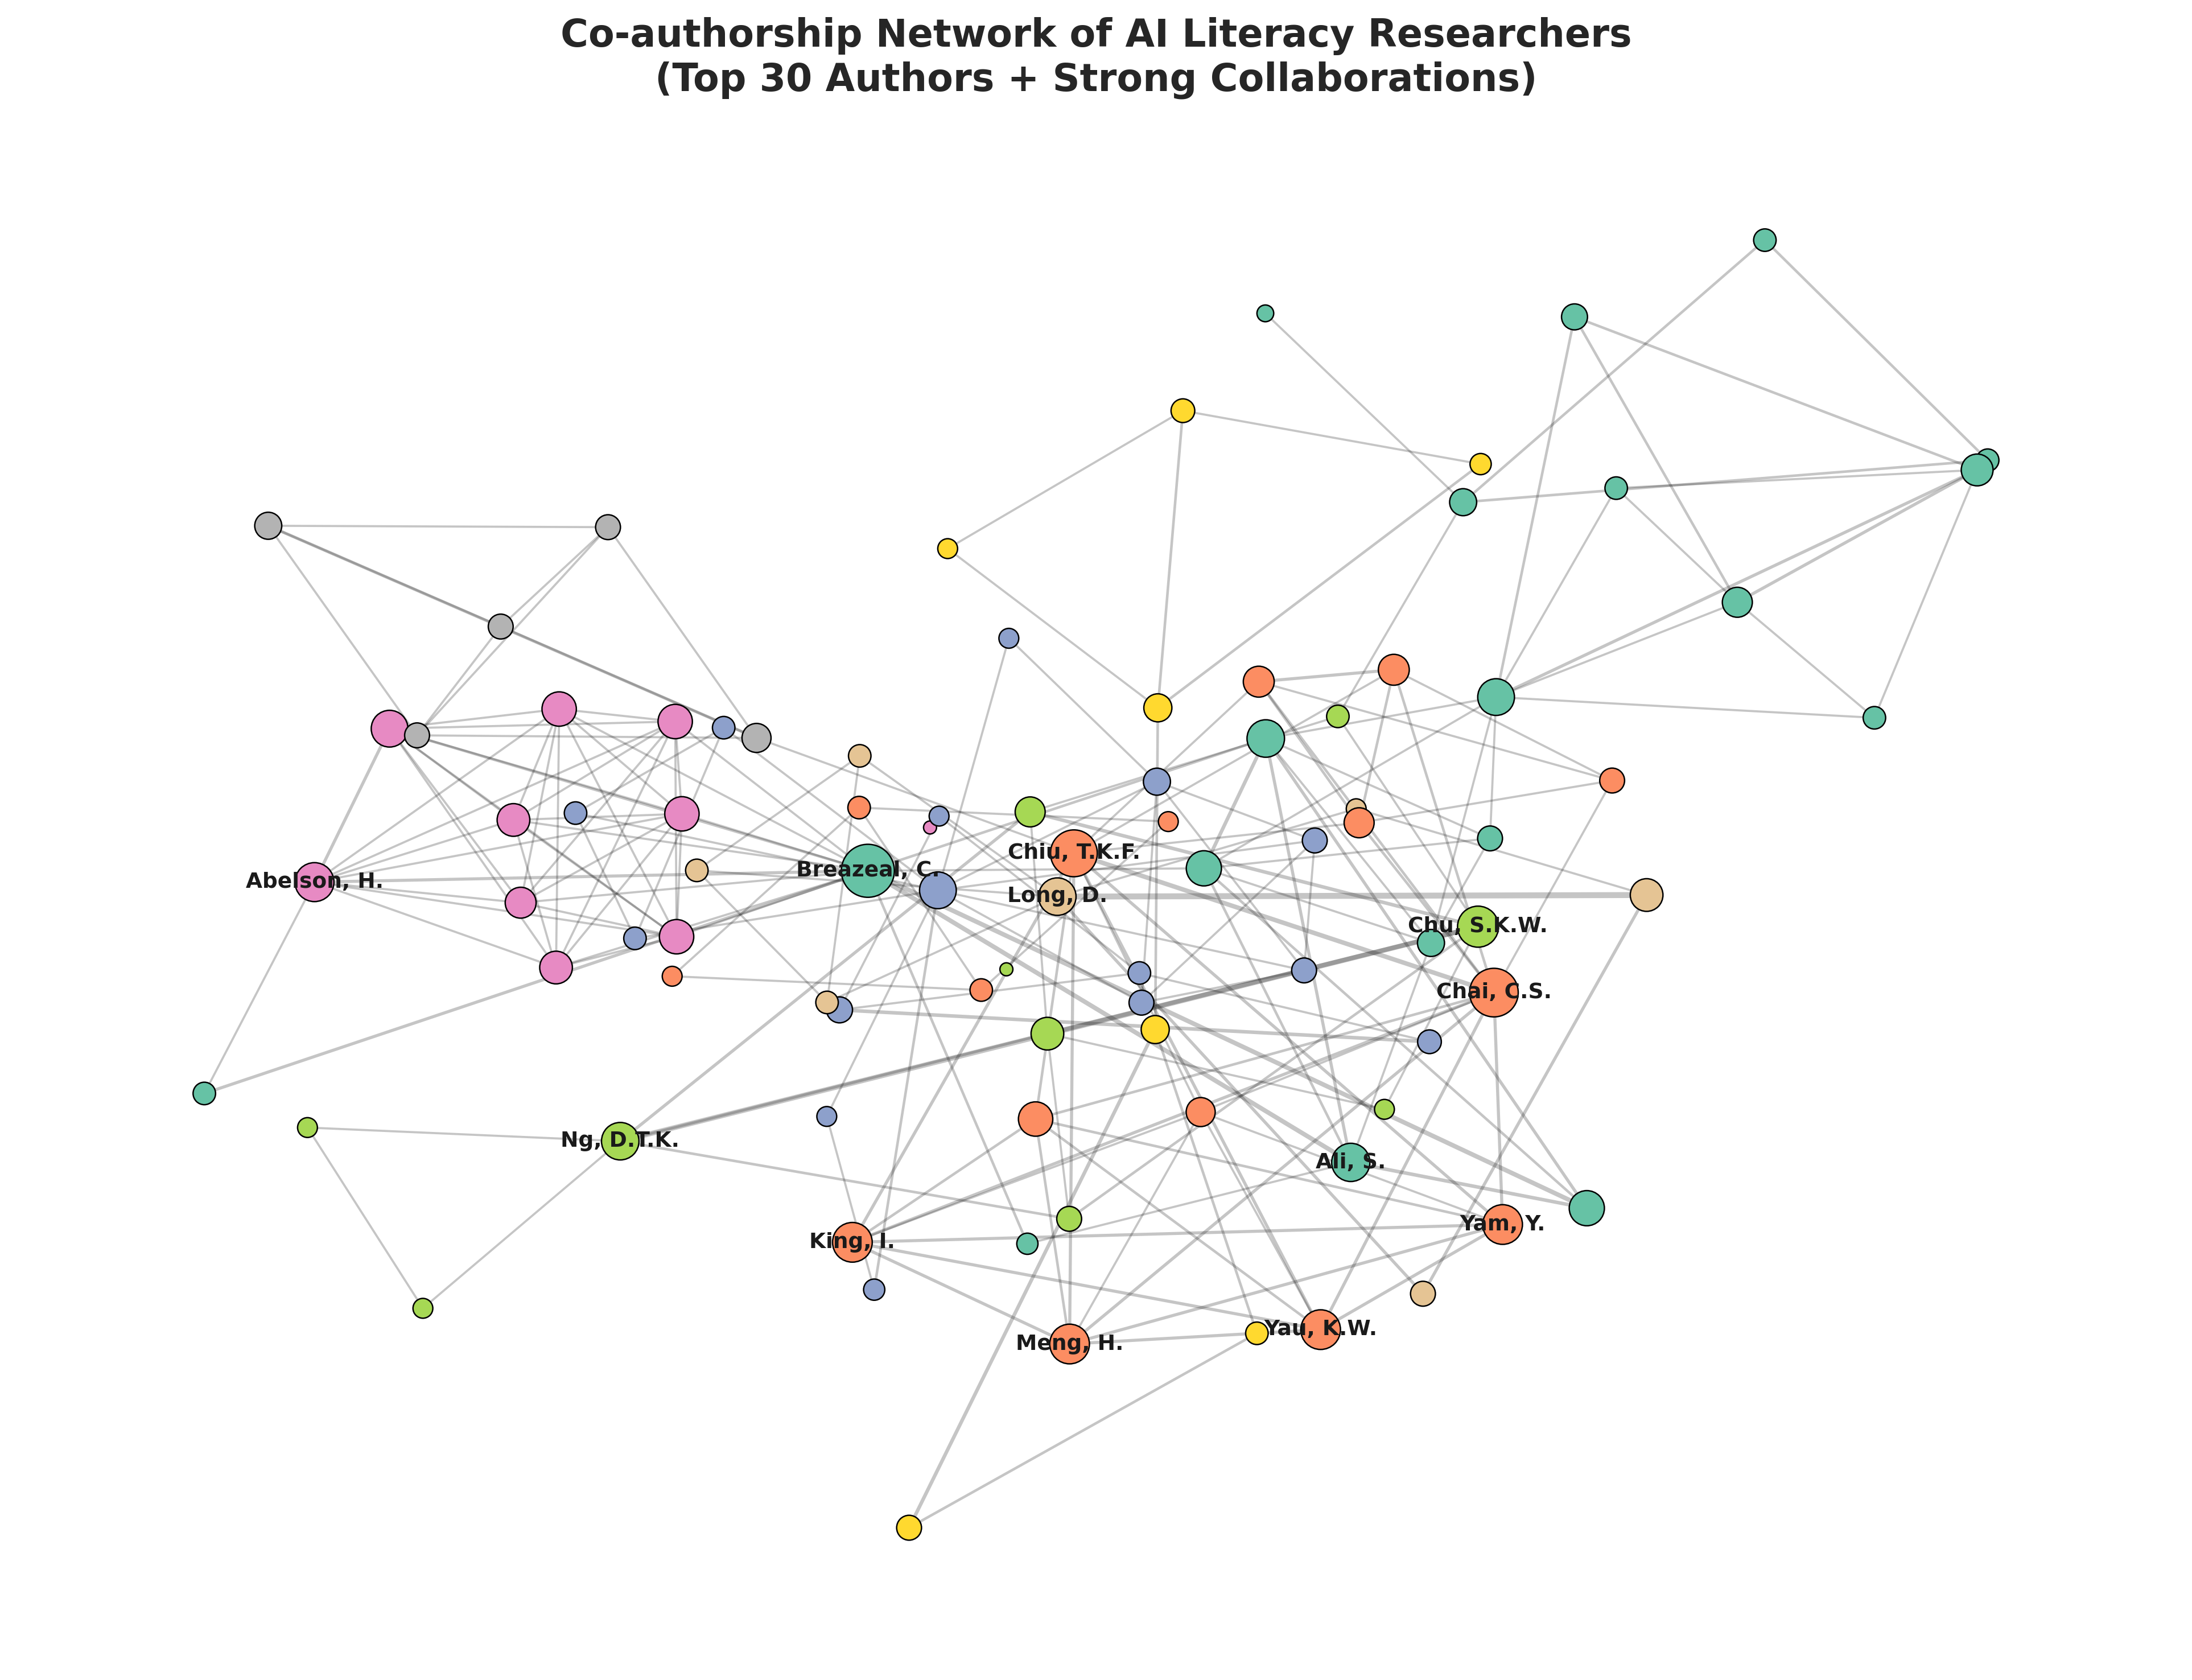

Top central authors by weighted degree:
Breazeal, C.: 47
Chai, C.S.: 39
Chiu, T.K.F.: 36
Chu, S.K.W.: 27
King, I.: 25
Meng, H.: 25
Yau, K.W.: 25
Yam, Y.: 25
Abelson, H.: 24
Ali, S.: 23
Ng, D.T.K.: 22
Long, D.: 22


In [ ]:
# Co-authorship Network (Top 30 authors + strong ties)

dfN = df.copy()
dfN['Cited by'] = pd.to_numeric(dfN['Cited by'], errors='coerce').fillna(0)

def split_authors(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return [a.strip() for a in str(x).split(';') if a.strip()]

dfN['author_list'] = dfN['Authors'].apply(split_authors)

invalid = ["", "nan", "none", "null", "n.a."]

explodedN = dfN.explode('author_list')
explodedN['author_list'] = explodedN['author_list'].astype(str).str.strip()
explodedN = explodedN[~explodedN['author_list'].str.lower().isin(invalid)]

author_prod = explodedN['author_list'].value_counts()

TOP_N = 30
core_authors = set(author_prod.head(TOP_N).index)

# Filter papers containing at least one core author
df_core = dfN[
    dfN['author_list'].apply(
        lambda lst: any(a in core_authors for a in (lst if isinstance(lst, list) else split_authors(lst)))
    )
]

# BUILD WEIGHTED CO-AUTHORSHIP NETWORK

G = nx.Graph()
edge_weights = {}

for _, row in df_core.iterrows():
    authors = row['author_list']
    authors = [a for a in authors if a.lower() not in invalid]
    authors = list(set(authors))

    for a in authors:
        G.add_node(a)

    for a, b in itertools.combinations(authors, 2):
        edge_weights[(a, b)] = edge_weights.get((a, b), 0) + 1

# PRUNE EDGES (KEEP ONLY STRONG TIES)

strong_edges = {(a,b): w for (a,b),w in edge_weights.items() if w >= 2}

G = nx.Graph()
for (a,b), w in strong_edges.items():
    G.add_edge(a, b, weight=w)

# Remove weak nodes (degree < 2)
weak_nodes = [n for n,d in G.degree() if d < 2]
G.remove_nodes_from(weak_nodes)

# CENTRALITY & COMMUNITIES

strength = dict(G.degree(weight='weight'))
communities = community.greedy_modularity_communities(G, weight='weight')

comm_map = {}
for i, comm in enumerate(communities):
    for n in comm:
        comm_map[n] = i


plt.figure(figsize=(13, 10), dpi=300)

pos = nx.kamada_kawai_layout(G)

node_sizes = [30 + 10*strength[n] for n in G.nodes()]

cmap = plt.cm.Set2
node_colors = [cmap(comm_map[n] % cmap.N) for n in G.nodes()]

weights = [G[u][v]['weight'] for u,v in G.edges()]
max_w = max(weights) if weights else 1
edge_widths = [0.5 + 2*(w/max_w) for w in weights]

nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.25)
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       edgecolors='black',
                       linewidths=0.6)

# Label top 12 most central authors
top12 = sorted(strength.items(), key=lambda x: x[1], reverse=True)[:12]
top12_names = [a for a,_ in top12]

labels = {n: (n if n in top12_names else "") for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels,
                        font_size=9, font_weight="bold")

plt.title("Co-authorship Network of AI Literacy Researchers\n(Top 30 Authors + Strong Collaborations)",
          fontsize=16, fontweight='bold')

plt.axis("off")
plt.tight_layout()
plt.show()

print("Top central authors by weighted degree:")
for a, s in top12:
    print(f"{a}: {s}")
